In [22]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.dpi'] = 80

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
players = pd.read_pickle('../TASK1/dataset/final_players.pkl')

In [3]:
players = players[players['stats_match_count'] >= 20]
players = players.loc[players.sex == 'm']

In [4]:
features = ['ace_ratio', 'svpt_1st_fail_ratio', 'svpt_2nd_w_ratio', 'bp_saved_ratio', 'bp_w_ratio', 'hard_w_ratio', 'clay_w_ratio']
clustering_data = players[features].dropna()
display(clustering_data)

,ace_ratio,svpt_1st_fail_ratio,svpt_2nd_w_ratio,bp_saved_ratio,bp_w_ratio,hard_w_ratio,clay_w_ratio
fullname,,,,,,,
kei nishikori,0.038567,0.38208,0.323317,0.623068,0.416226,0.005321,-0.008245
daniil medvedev,0.10336,0.404673,0.319396,0.631318,0.427549,0.038457,-0.189519
jo-wilfried tsonga,0.123616,0.391861,0.298824,0.672508,0.379675,0.029716,-0.073542
jeremy chardy,0.103885,0.378707,0.288876,0.620095,0.37779,0.004002,-0.025814
alex de minaur,0.046221,0.401622,0.337878,0.612808,0.407603,0.029491,-0.212697
...,...,...,...,...,...,...,...
arjun kadhe,0.057913,0.32079,0.254545,0.594005,0.394636,0.025686,-0.139847
tom jomby,0.104906,0.397704,0.318342,0.59,0.405172,0.022989,-0.310345
sergio gutierrez ferrol,0.048461,0.409627,0.322999,0.583333,0.408046,-0.26,0.092632


---

# DBScan

In [5]:
scaler_std = StandardScaler()
clustering_data_std = scaler_std.fit_transform(clustering_data.values)

According to *(Sander et al., Density-Based Clustering in Spatial Databases: The Algorithm GDBSCAN and Its Applications, 1998)* with dimensionality > 2, a valid heuristic is to choose *minPts* as <u>twice the dimensionality of the data</u>.

In [6]:
minPts = 2 * len(features)

We execute the first `DBSCAN` clustering choosing as parameter $\epsilon = 1.5$ and the *minPts* described above.

In [20]:
dbscan = DBSCAN(eps=1.5, min_samples=minPts)
dbscan.fit(clustering_data_std)

clusteringA = clustering_data.copy()
clusteringA['cluster'] = dbscan.labels_

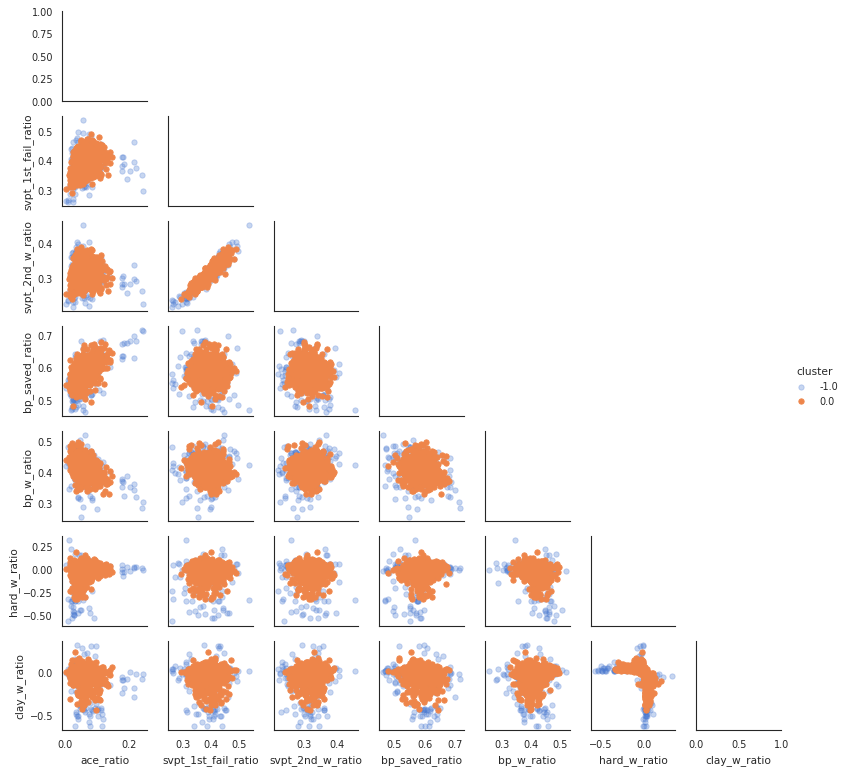

In [23]:
sns.set_style('white')
g = sns.PairGrid(data=clusteringA.astype(float), hue="cluster", palette='muted', hue_kws={"alpha": [0.3, 1]}, corner=True, height=1.4)
g = g.map_lower(plt.scatter)
g = g.add_legend()
plt.show()

As we can see two clusters are outputted which seems to effectively highlight the different distributions of the features. 

The cluster *-1* gathers the noise points

## Knee Method: finding the optimal $\epsilon$

As we know the optimal parameter of $\epsilon$ can be found looking at the behavior of the distance from a point to its $k^{th}$ nearest neighbor, where $k$ is set to the *minPts* value. The *knee* will be our *optimal* $\epsilon$ value.

In [9]:
from sklearn.neighbors import NearestNeighbors

We search through a range of *minPts* values between $3$ and twice the dimensionality of the data.

For finding the *knee* of the sorted distances we take advantage of the package [`kneed`](https://pypi.org/project/kneed/) which is a package implementing the [kneedle algorithm](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf). 

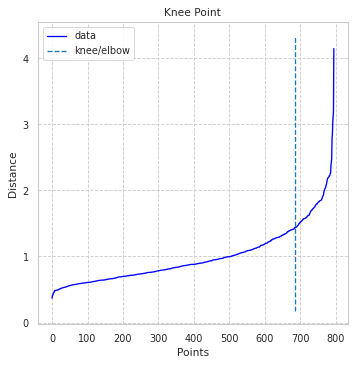

[ minPts=3, eps=1.435, k=5]


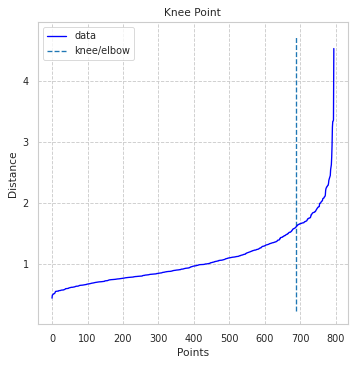

[ minPts=4, eps=1.605, k=3]


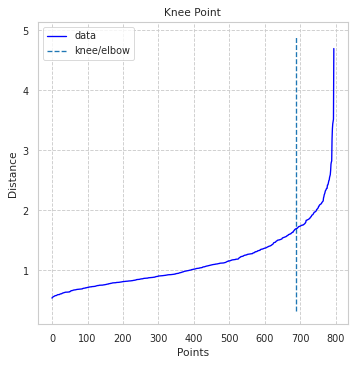

[ minPts=5, eps=1.692, k=2]


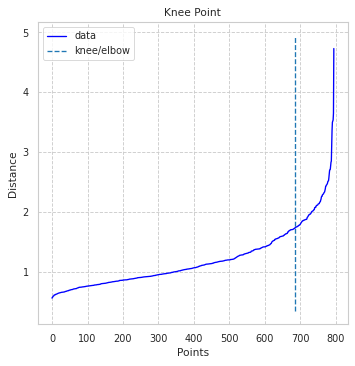

[ minPts=6, eps=1.735, k=1]


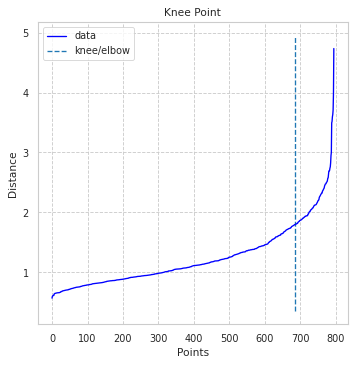

[ minPts=7, eps=1.799, k=1]


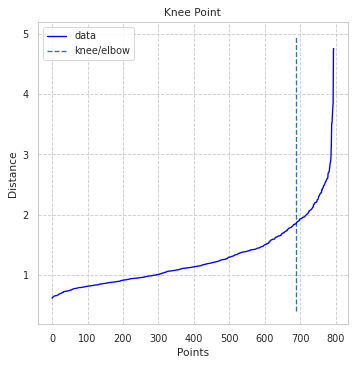

[ minPts=8, eps=1.853, k=1]


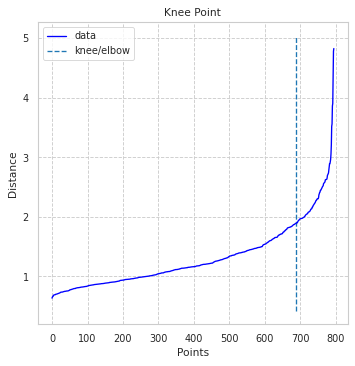

[ minPts=9, eps=1.896, k=1]


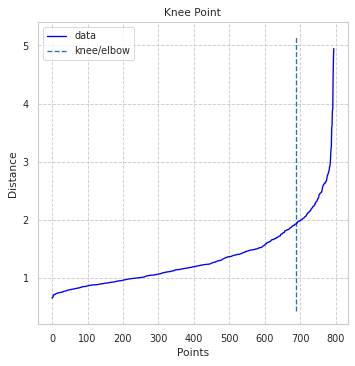

[ minPts=10, eps=1.929, k=1]


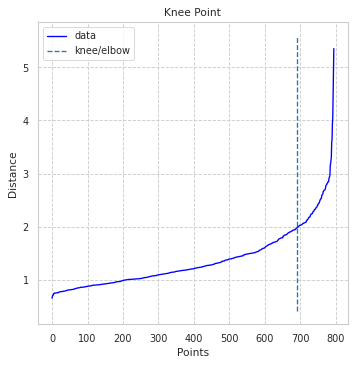

[ minPts=11, eps=1.976, k=1]


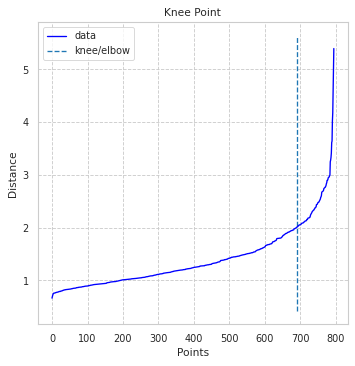

[ minPts=12, eps=1.999, k=1]


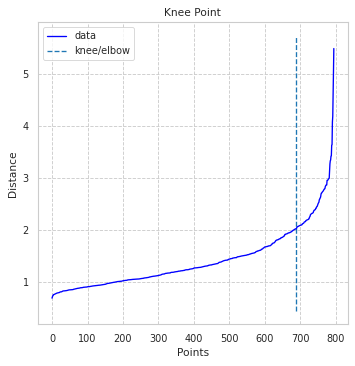

[ minPts=13, eps=2.03, k=1]


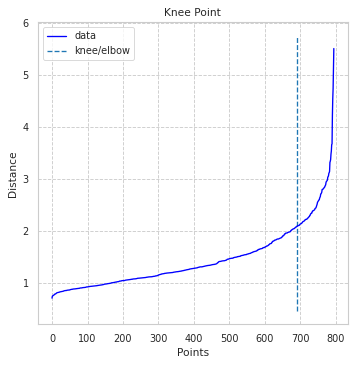

[ minPts=14, eps=2.077, k=1]


In [10]:
from kneed import KneeLocator

minPts_list = list(range(3, 2*len(features)+1))

for minPts in minPts_list:
    neighbors = NearestNeighbors(n_neighbors=minPts)
    neighbors_fit = neighbors.fit(clustering_data_std)
    distances, indices = neighbors_fit.kneighbors(clustering_data_std)
    distances = np.sort(distances, axis=0)
    distances = distances[:, minPts - 1]
    
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    knee.plot_knee(figsize=(5, 5))
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()

    eps_opt = round(distances[knee.knee], 3)
    
    dbscan_opt = DBSCAN(eps=eps_opt, min_samples=minPts)
    dbscan_opt.fit(clustering_data_std)

    print(f'[ minPts={minPts}, eps={eps_opt}, k={len(np.unique(dbscan_opt.labels_)) - 1}]')

The algorithm found several optimal $\epsilon$ values, each for every *minPts* considered

---

## Optimal DBSCAN

Now we can recompute the clusters using the new pair of values of $\epsilon$ and *minPts*, focusing on the following ones:
- clustering A: minPts=3, eps=1.435, k=5
- clustering B: minPts=4, eps=1.605, k=3
- clustering C: minPts=5, eps=1.692, k=2
- clustering D: minPts=14, eps=2.077, k=1

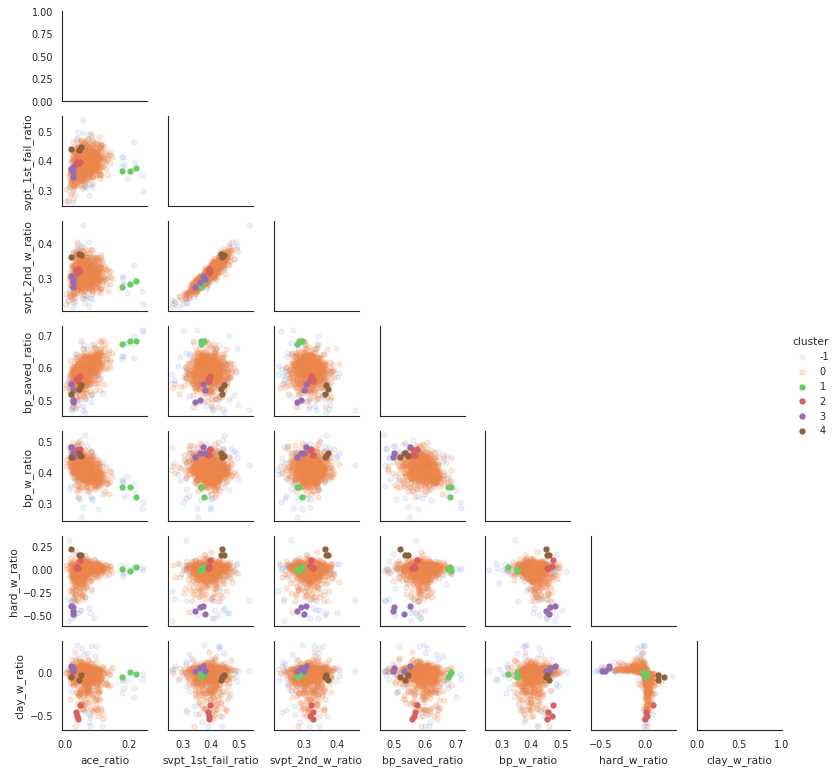

In [24]:
dbscan_opt = DBSCAN(eps=1.435, min_samples=3)
dbscan_opt.fit(clustering_data_std)

clusteringA = clustering_data.copy()
clusteringA['cluster'] = dbscan_opt.labels_

sns.set_style('white')
g = sns.PairGrid(data=clusteringA, hue="cluster", palette='muted', hue_kws={"alpha": [0.1, 0.2, 1, 1, 1, 1]}, corner=True, height=1.4)
g = g.map_lower(plt.scatter)
g = g.add_legend()
plt.show()

Let's see which players compose the cluster 1 (the green one)

In [12]:
clusteringA[clusteringA.cluster == 1]

,ace_ratio,svpt_1st_fail_ratio,svpt_2nd_w_ratio,bp_saved_ratio,bp_w_ratio,hard_w_ratio,clay_w_ratio,cluster
fullname,,,,,,,,
milos raonic,0.201646,0.366478,0.285483,0.682956,0.352538,-0.020179,0.005349,1
kevin anderson,0.177438,0.363707,0.277129,0.673766,0.352524,0.002811,-0.051726,1
reilly opelka,0.220788,0.376082,0.292681,0.680921,0.320038,0.026955,-0.020811,1


They're the players with high ace, except that some of them are missing because they are considered noise (cluster -1, the blue one)

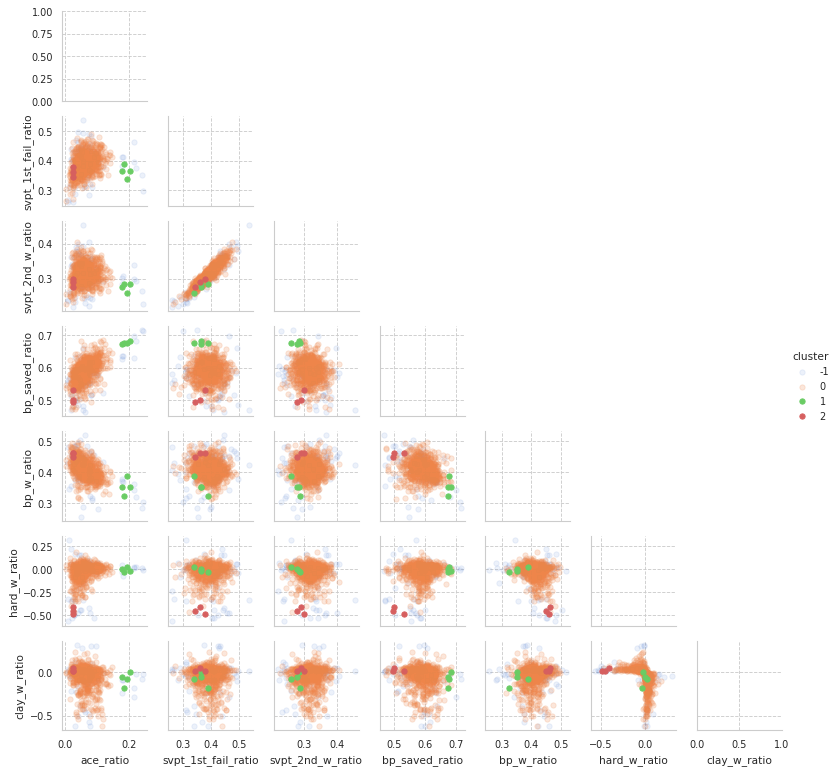

In [13]:
dbscan_opt = DBSCAN(eps=1.605, min_samples=4)
dbscan_opt.fit(clustering_data_std)

clusteringB = clustering_data.copy()
clusteringB['cluster'] = dbscan_opt.labels_

g = sns.PairGrid(data=clusteringB, hue="cluster", palette='muted', hue_kws={"alpha": [0.1, 0.2, 1, 1]}, corner=True, height=1.4)
g = g.map_lower(plt.scatter)
g = g.add_legend()
plt.show()

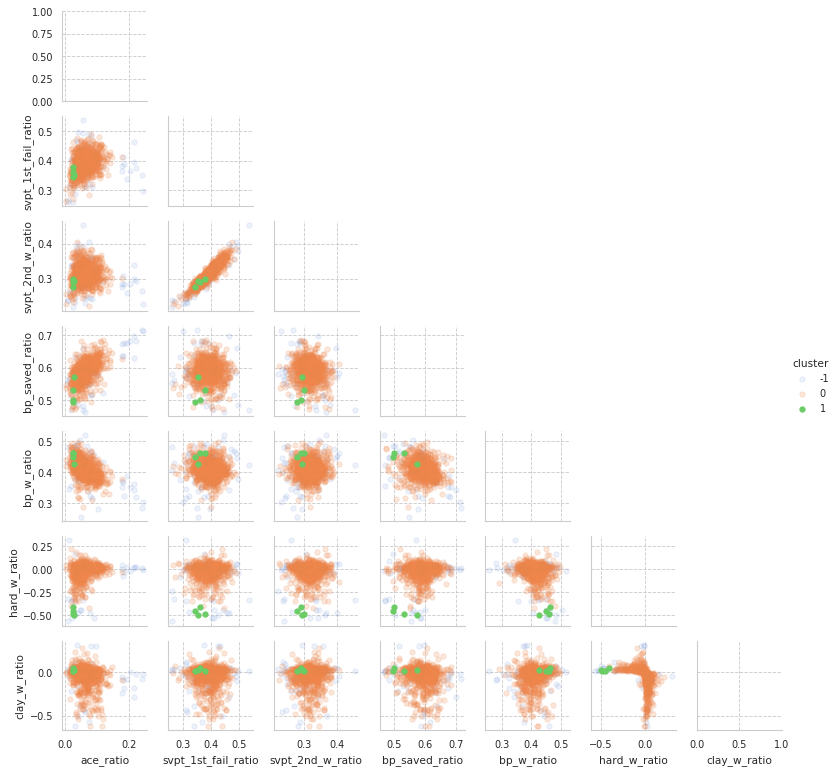

In [14]:
dbscan_opt = DBSCAN(eps=1.692, min_samples=5)
dbscan_opt.fit(clustering_data_std)

clusteringC = clustering_data.copy()
clusteringC['cluster'] = dbscan_opt.labels_

g = sns.PairGrid(data=clusteringC, hue="cluster", palette='muted', hue_kws={"alpha": [0.1, 0.2, 1]}, corner=True, height=1.4)
g = g.map_lower(plt.scatter)
g = g.add_legend()
plt.show()

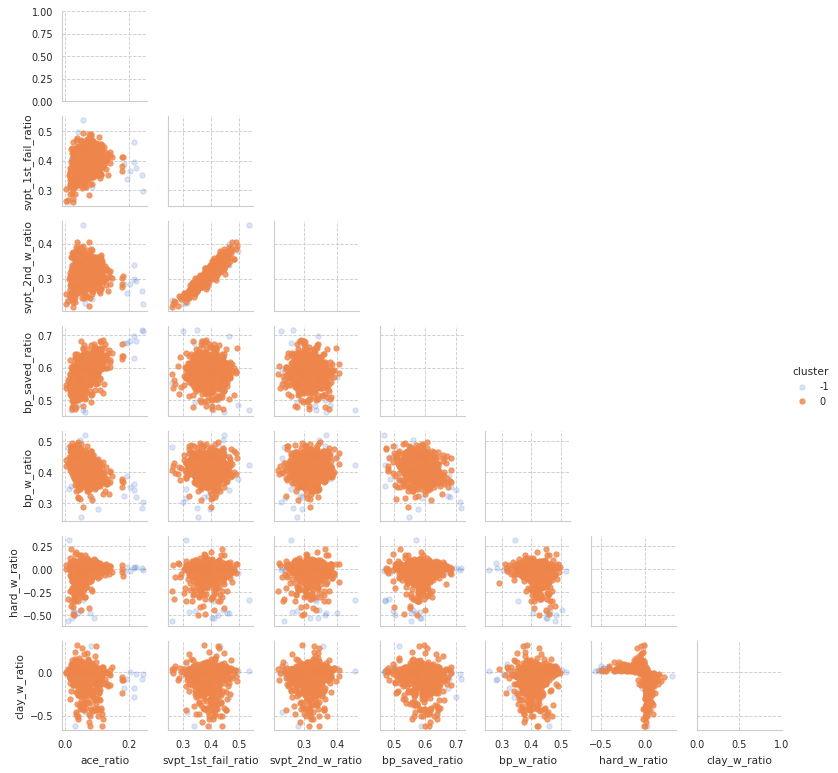

In [15]:
dbscan_opt = DBSCAN(eps=2.077, min_samples=14)
dbscan_opt.fit(clustering_data_std)

clusteringD = clustering_data.copy()
clusteringD['cluster'] = dbscan_opt.labels_

g = sns.PairGrid(data=clusteringD, hue="cluster", palette='muted', hue_kws={"alpha": [0.2, 0.8]}, corner=True, height=1.4)
g = g.map_lower(plt.scatter)
g = g.add_legend()
plt.show()

However, in the light of the findings, the use of `DBSCAN` is not suitable for our purposes, since it can not be used to extract *style of players* from the density of the data. Moreover, it is well known that the algorithm has trouble with high-dimensional data because density is more difficult to define for such data.

For this reason, <u>we will not proceed to apply this kind of clustering on the remaining data of the dataset</u>.